In [ ]:
!pip install gym


In [86]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from google.colab import widgets
import time
import math
import pandas as pd
from statistics import mean
from itertools import chain
import random



Environment

In [130]:

class GridEnvironment(gym.Env):

#Stochasticy is by default set to false
    def __init__(self, stochasticy=False):
        #observation sapace is the total number of states in the game
        self.observation_space = spaces.Discrete(25)
        #total number of actions that can be taken
        self.action_space = spaces.Discrete(4)
        #max number of time step per eposides
        self.max_timesteps = 50
        self.stochasticy = stochasticy

    def reset(self):
        self.timestep = 0
        self.totalreward = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [4, 4]
        self.monster_pos = [2, 3]
        self.diamond_pos = [4, 2]
        self.diamond_taken = False
        self.monster_killed = False

        self.state = np.zeros((5, 5))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.diamond_pos)] = 0.25
        self.state[tuple(self.monster_pos)] = 0.15
        observation = self.agent_pos
        return observation

    def step(self, action):
#gets the prervious location of the agent before updating it.
        agent_old_pos = self.agent_pos.copy()
#if stochasticy is true then there is a 10% that an agent will not pick the action it was supposed to pick
#10% is achived as the intial prob is 10.25% of picking any random action but as one of the random actions 
#can be the orginal action hence the overall propabilty of picking a different random action is 10%
        if (self.stochasticy == True):          
            if (np.random.choice((0, 1), p=[0.1025, 0.8975]) == 0):
                action = np.random.choice(self.action_space.n)

        # down
        if action == 0:
            self.agent_pos[0] += 1
        # up
        if action == 1:
            self.agent_pos[0] -= 1
        # left
        if action == 2:
            self.agent_pos[1] += 1
        # right
        if action == 3:
            self.agent_pos[1] -= 1

        self.agent_pos = np.clip(self.agent_pos, 0, 4)
        self.state = np.zeros((5, 5))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.diamond_pos)] = 0.25
        self.state[tuple(self.monster_pos)] = 0.15
        observation = self.agent_pos

        reward = 0
#if agent reaches the goal it gets 500 in reward
        if (self.agent_pos == self.goal_pos).all():
            reward += 500
#if agent reaches the monster it gets a minus five penelty. The moster_killed variable is used to make sure that the agent can only touch the monster ones
        if ((self.agent_pos == self.monster_pos).all() and self.monster_killed == False) :
            reward += -5
            self.monster_killed =True
#if agent reaches the diamond it gets a plus 10 reward. The diamond_taken variable is used to make sure that the agent can only take the reward ones
        if ((self.agent_pos == self.diamond_pos).all()and self.diamond_taken == False):
            reward += 10
            self.diamond_taken = True

# distance from Goal
# The distance between two points measured along axes at right angles. In a plane with p1 at (x1, y1) and p2 at (x2, y2), it is |x1 - x2| + |y1 - y2|.

        x1 = agent_old_pos[1]
        y1 = agent_old_pos[0]

        x2 = self.goal_pos[1]
        y2 = self.goal_pos[0]
#distance of old postion from the goal
        olddistance = abs(x1 - x2) + abs(y1 - y2)

        x1 = self.agent_pos[1]
        y1 = self.agent_pos[0]

#checking to see if the agent as reach the goal
        reached = True if (x1 == x2 and y1 == y2) else False

        newdistance = abs(x1 - x2) + abs(y1 - y2)

#checking to see if the new distance is less than the old distance to see if the agent has gotten closer or further away from the goal

#Plus 3 reward for comming closer and -5 reward for staying at the same place or going further back.
        if newdistance < olddistance:
            reward += 3
        else:
            reward -= 5

        self.totalreward += reward
        self.timestep += 1

        done = True if (self.timestep >= self.max_timesteps) or (reached) else False
        info = {}

        return observation, reward, done, info, self.totalreward,reached

    def render(self):
        plt.imshow(self.state)

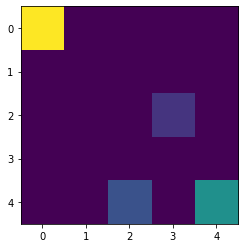

In [7]:
env = GridEnvironment()
obs = env.reset()
env.render()

A Random Agent


In [131]:

#References used to implement the code:
#https://www.youtube.com/watch?v=gpukolRpkxo&ab_channel=AIInsights-RiturajKaushik
#https://www.geeksforgeeks.org/sarsa-reinforcement-learning/ 

class Agent:
#global list that will contains all the hyper paraments
    hyper_parameters = {}

#Function to set all the hyperparamenter
#the discount_factor, alpha and epsilon_decay_rate are taken in from the user at runtime
#while the epsilon_min,epsilon_max and max_number_of_episodes all have defalut values 
    def setHyperparameters(self,discount_factor,alpha,epsilon_decay_rate):
        self.hyper_parameters["discount_factor"] = discount_factor
        self.hyper_parameters["alpha"] = alpha
        self.hyper_parameters["epsilon_decay_rate"] = epsilon_decay_rate

#default value of epsilon_min = 0.1
        self.hyper_parameters["epsilon_min"] = 0.1

#default value of epsilon_max = 1
        self.hyper_parameters["epsilon_max"] = 1
        self.hyper_parameters["epsilon_current"] = 1

#default value of max_number_of_episodes = 1000
        self.hyper_parameters["max_number_of_episodes"] = 1000

#the values for discount_factor,alpha,epsilon_decay_rate are expected at runtimes but default values are also set.
#the default value where chosen based on testing the agent with various different values.
    def __init__(self, env,discount_factor = 0.9, alpha = 0.3, epsilon_decay_rate = 0.996):
        self.env = env
        self.stochasticy = env.stochasticy
        self.observation_space = env.observation_space
        self.action_space = env.action_space

        self.current_qtrow = self.qtrow(env.agent_pos)
        self.current_num_eposide = 0
        self.setHyperparameters(discount_factor,alpha,epsilon_decay_rate)

    def decay(self):
#the decay funtion muplties the epsilon with the decay rate and put's it back to the epsilon
#before the decay is done, it's check to see if the epsilon is aready not lower than the min, if it is then the min value is returned.
        if (self.hyper_parameters["epsilon_current"] > self.hyper_parameters["epsilon_min"]):
            decayep = self.hyper_parameters["epsilon_decay_rate"]
            newEp = self.hyper_parameters["epsilon_current"] * decayep
            self.hyper_parameters["epsilon_current"] = newEp

        if(self.hyper_parameters["epsilon_current"] > self.hyper_parameters["epsilon_max"]):
            self.hyper_parameters["epsilon_current"] = self.hyper_parameters["epsilon_max"]



#method used to take the greedy step. with the input being the Qtable and the number of the row of the qtable which signifies the state 
    def greedystep(self, qtable,qtrow):
#the current epsilon
        epsilon = self.hyper_parameters["epsilon_current"]
#As the greedy algorithm is:
#With probability epsilon choose a random action a
#With probability 1 − epsilon choose “greedy” action a with the highest Q-value.
#Function to pick either 0 or 1. The probabilty of zero is 1-epsilon while the probabilty of 1 is epsilon
#if zero is picked then the greedy step is taken and if 1 is picked then a random step is taken
        ranNum = np.random.choice((0, 1), p=[1-epsilon, epsilon])
        if (ranNum == 0 ):
            return np.argmax(qtable[qtrow, :])
        else:
            return np.random.choice(self.action_space.n)

    def step(self, qtable, qtrow):
        nextStep = self.greedystep(qtable, qtrow)
        return nextStep

#This function takens in the corroditans of a state and turns them into a tuple that respents the respective row number in the Qtable. 
#The formuala used for this is row number = Y + X * total number of x values in the grid.
    def qtrow(self, observation):
        col_num = math.sqrt(self.observation_space.n)
        flat_row = observation[1] + (observation[0] * col_num)
        return int(flat_row)

#Function to reinitialize the environment after every eposide.
    def newEposide(self):
        self.env.reset()
        obs = self.env.agent_pos
        self.current_qtrow = self.qtrow(obs)
        self.current_num_eposide += 1

#Function to update the QTable in the SARSA Algorthim
    def update_table_SARSA(self,qtable,reward,obs,initial_action,action_new):
        new_row = self.qtrow(obs)  # State_prime
        qt_position = tuple((int(self.current_qtrow), initial_action)) #Position  of Q(S,A) in the Qtable
        old_reward = qtable[qt_position] #Current value in the QTable at the position Q(S,A) 
        #New value to for the poistion Q(S,A) = Q(S,A) + alpha * [Reward + Gama * Q(State_prime,Aaction_prim) - Q(S,A)]
        new_reward = old_reward + self.hyper_parameters['alpha'] * (reward + (self.hyper_parameters['discount_factor'] * qtable[ tuple((int(new_row), action_new))]) - old_reward)
        qtable[qt_position] = new_reward #Putting the new value in Q(S,A)
        self.current_qtrow = new_row #Updating State to State prime

#Function to update the QTable in the SARSA Algorthim
    def update_table_Qlearning(self,qtable,reward,new_row,action):
        qt_position = tuple((int(self.current_qtrow), action))   #Position  of Q(S,A) in the Qtable
        old_reward = qtable[qt_position] #Current value in the QTable at the position Q(S,A)
        #New value to for the poistion Q(S,A) = Q(S,A) + alpha * [Reward  + ( Gama * max value(Q(State_prime) )- Q(S,A)]
        new_reward = old_reward + self.hyper_parameters['alpha'] * (reward + (self.hyper_parameters['discount_factor'] * np.max(qtable[new_row, :])) - old_reward)
        qtable[qt_position] = new_reward #Putting the new value in Q(S,A)
        self.current_qtrow = new_row# Updating State to State prime

#end of qlearning --------------------------------------------------------------------------------------------------------------------------------------------------------------------
    def qlearning(self):
      #list to store all total reawrd after reach epoisde
        reward_for_eposide = []
      #list to store the value of epsilon after every eposide
        epsilon_for_eposide = []
      #list to store the path length, i.e. totol number of actions taken by the agent before ending the eposide. 
        path_len_per_eq= []
      #list to store if the agent reached the final position of not
        reached_goal = []
        num_state = self.observation_space.n
        action_num = self.action_space.n
        #creating the Qtable as a numpy array wiht 25 rows and 4 coloums and filling with up with zeros
        qtable = np.zeros((num_state, action_num))
#for loop that runs from 0 to max num of eposides--------------------------------------------------------------------------------------------------------------------------------------------------------------------
        for ep in range(self.hyper_parameters["max_number_of_episodes"]):
            self.newEposide()
            done = False
            totalReward = 0
            pathLen = 0
            goal_reached = False
            current_qtrow = self.current_qtrow #initial stage of the agent in the form of row number in Qtable
#while loop--------------------------------------------------------------------------------------------------------------------------------------------------------------------            
            while not done:
                action = self.step(qtable,current_qtrow) #action picked
                #agent made to do the action in the environment
#The new poisition of the agent, the reward for the action, if the eposide is complete or not, extra info, the total reward for the complete eposide, if the agent reached the final position or not is returned  
                obs, reward, done, info, totalReward,reached = self.env.step(action)
                pathLen += 1 # pathlen is increased by one
                goal_reached = reached 
                new_qtrow = self.qtrow(obs)  #the new poistion is turned into it's respetive row number in the Qtable
                self.update_table_Qlearning(qtable,reward,new_qtrow,action) #Qtable is updated
#while loop end--------------------------------------------------------------------------------------------------------------------------------------------------------------------            
            self.decay() # Epsilon is decayed
            reward_for_eposide.append(totalReward) 
            epsilon_for_eposide.append(self.hyper_parameters["epsilon_current"])
            path_len_per_eq.append(pathLen)
            reached_goal.append(goal_reached)
#for end loop--------------------------------------------------------------------------------------------------------------------------------------------------------------------   
        return reward_for_eposide,epsilon_for_eposide,path_len_per_eq,reached_goal
#end of qlearning --------------------------------------------------------------------------------------------------------------------------------------------------------------------

#start of sarsa --------------------------------------------------------------------------------------------------------------------------------------------------------------------
    def sarsa(self):
        #list to store all total reawrd after reach epoisde
        reward_for_eposide = []
        #list to store the value of epsilon after every eposide
        epsilon_for_eposide = []
        #list to store the path length, i.e. totol number of actions taken by the agent before ending the eposide.
        path_len_per_eq= []
        #list to store if the agent reached the final position of not
        reached_goal = []
      
        #creating the Qtable as a numpy array wiht 25 rows and 4 coloums and filling with up with zeros
        num_state = self.observation_space.n
        action_num = self.action_space.n
        qtable = np.zeros((num_state, action_num))

#for loop that runs from 0 to max num of eposides--------------------------------------------------------------------------------------------------------------------------------------------------------------------
        for ep in range(self.hyper_parameters["max_number_of_episodes"]):
            done = False
            totalReward = 0
            pathLen = 0
            path = []
            self.newEposide()
            current_qtrow = self.current_qtrow
            #initial action is chosen
            initial_action = self.step(qtable,current_qtrow)
            goal_reached = False
#while loop--------------------------------------------------------------------------------------------------------------------------------------------------------------------            
            while not done:
 #agent made to do the initial action in the environment
#The new poisition of the agent, the reward for the action, if the eposide is complete or not, extra info, the total reward for the complete eposide, if the agent reached the final position or not is returned  
              obs, reward, done, info, totalReward,reached = self.env.step(initial_action)
              goal_reached = reached
              new_qtrow = self.qtrow(obs)  #the new poistion is turned into it's respetive row number in the Qtable
              action_new = self.step(qtable,new_qtrow) # a new action is chosen based on the new row
              self.update_table_SARSA(qtable,reward,obs,initial_action,action_new) # The Qtable is updated
              initial_action = action_new # The new action is now used as the initial action
              pathLen += 1
#while loop end--------------------------------------------------------------------------------------------------------------------------------------------------------------------            

            self.decay() # Epsilon is decayed
            reward_for_eposide.append(totalReward)
            epsilon_for_eposide.append(self.hyper_parameters["epsilon_current"])
            path_len_per_eq.append(pathLen)
            reached_goal.append(goal_reached)
#for end loop--------------------------------------------------------------------------------------------------------------------------------------------------------------------         
        return reward_for_eposide,epsilon_for_eposide,path_len_per_eq,reached_goal
#end of sarsa --------------------------------------------------------------------------------------------------------------------------------------------------------------------


Panda data frame to store the values of the hyperparamenters 

In [134]:
hyper_paramenters = ["discount_factor","alpha","epsilon_decay_rate"]
df = pd.DataFrame(columns= hyper_paramenters)
values_alpha = [0.3,0.6,0.9]
values_ep = [0.992,0.994,0.996]
for a in values_alpha:
      for b in values_alpha:
          for c in values_ep:
              df2 = pd.DataFrame({"discount_factor" : [a], "alpha" : [b], "epsilon_decay_rate" : [c]})
              df = df.append(df2)

df = df.drop_duplicates().reset_index(drop=True)

df["reward_for_eposide"] = ""
df["epsilon_for_eposide"] = ""
df["path_len_per_eq"]= ""
df["reached_goal"] = ""


All the combinations of hyperparameters that were used to run the algrothims

---



In [135]:
df

,discount_factor,alpha,epsilon_decay_rate,reward_for_eposide,epsilon_for_eposide,path_len_per_eq,reached_goal
0,0.3,0.3,0.992,,,,
1,0.3,0.3,0.994,,,,
2,0.3,0.3,0.996,,,,
3,0.3,0.6,0.992,,,,
4,0.3,0.6,0.994,,,,
5,0.3,0.6,0.996,,,,
6,0.3,0.9,0.992,,,,
7,0.3,0.9,0.994,,,,
8,0.3,0.9,0.996,,,,
9,0.6,0.3,0.992,,,,


Running Q-Learning on all the parameters in a determinstic environment

---





In [136]:

index = 0
for i, j in dfsarsa.iterrows(): 
    discount_factor = j[0]
    alpha = j[1]
    epsilon_decay_rate = j[2]
    env = GridEnvironment(False)
    obs = env.reset()
    obs = env.reset()
    agent = Agent(env,discount_factor,alpha,epsilon_decay_rate)
    reward_for_eposide,epsilon_for_eposide,path_len_per_eq,reached_goal= agent.qlearning()
    df["reward_for_eposide"][index] = reward_for_eposide
    df["epsilon_for_eposide"][index] = epsilon_for_eposide
    df["path_len_per_eq"][index]= path_len_per_eq
    df["reached_goal"][index] = reached_goal
    index += 1
    
   


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/l

Function to plot graphs

In [30]:
def plot_graph(df,y_axis,title):
  coloums = []
  for c, rows in df.iterrows():
    coloums.append(c)

#plot 1------------------------------------------------------------------------
  yvalue = df[y_axis][coloums[0]]
  xvalue = range(0,1000)

  fig, ax = plt.subplots()

  if (y_axis == "reward_for_eposide"):
    point1 = [0, 540]
    point2 = [1000, 540]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]

    plt.plot(x_values, y_values,label='max value obtainable in the environment')
    leg = ax.legend()


    # plotting the points  
  ax.plot(xvalue, yvalue) 
  
    # naming the x axis 
  ax.set_xlabel('Episodes') 
    # naming the y axis 
  ax.set_ylabel(y_axis) 

  
    # giving a title to my graph 
  ax.title.set_text(title)

  discount_factor = df["discount_factor"][coloums[0]]		
  alpha = df["alpha"][coloums[0]]
  epsilon_decay_rate = df["epsilon_decay_rate"][coloums[0]]
  textstr = '\n'.join((
  r'Discount factor=%s' % (discount_factor),
  r'Alpha=%s' % (alpha),
  r'Epsilon Decay Rate=%s' % (epsilon_decay_rate)))


    # place a text box in upper left in axes coords
  ax.text(0.3, 1, textstr, fontsize=14, transform=plt.gcf().transFigure)
#plot 1 end------------------------------------------------------------------------
#plot 2------------------------------------------------------------------------

  yvalue = df[y_axis][coloums[1]]
  xvalue = range(0,1000)

  fig, ax = plt.subplots()

  if (y_axis == "reward_for_eposide"):
    point1 = [0, 540]
    point2 = [1000, 540]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]

    plt.plot(x_values, y_values,label='max value obtainable in the environment')
    leg = ax.legend()

    # plotting the points  
  ax.plot(xvalue, yvalue) 
  
    # naming the x axis 
  ax.set_xlabel('Episodes') 
    # naming the y axis 
  ax.set_ylabel(y_axis) 

  
    # giving a title to my graph 
  ax.title.set_text(title)

  discount_factor = df["discount_factor"][coloums[1]]		
  alpha = df["alpha"][coloums[1]]
  epsilon_decay_rate = df["epsilon_decay_rate"][coloums[1]]
  textstr = '\n'.join((
  r'Discount factor=%s' % (discount_factor),
  r'Alpha=%s' % (alpha),
  r'Epsilon Decay Rate=%s' % (epsilon_decay_rate)))



    # place a text box in upper left in axes coords
  ax.text(0.3, 1, textstr, fontsize=14, transform=plt.gcf().transFigure)
#plot 2 end------------------------------------------------------------------------

#plot 3------------------------------------------------------------------------

  yvalue = df[y_axis][coloums[2]]
  xvalue = range(0,1000)

  fig, ax = plt.subplots()

  if (y_axis == "reward_for_eposide"):
    point1 = [0, 540]
    point2 = [1000, 540]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]

    plt.plot(x_values, y_values,label='max value obtainable in the environment')
    leg = ax.legend()


  # plotting the points  
  ax.plot(xvalue, yvalue) 
  
  # naming the x axis 
  ax.set_xlabel('Episodes') 
  # naming the y axis 
  ax.set_ylabel(y_axis) 

  
    # giving a title to my graph 
  ax.title.set_text(title)

  discount_factor = df["discount_factor"][coloums[2]]		
  alpha = df["alpha"][coloums[2]]
  epsilon_decay_rate = df["epsilon_decay_rate"][coloums[2]]
  textstr = '\n'.join((
  r'Discount factor=%s' % (discount_factor),
  r'Alpha=%s' % (alpha),
  r'Epsilon Decay Rate=%s' % (epsilon_decay_rate)))


    # place a text box in upper left in axes coords
  ax.text(0.3, 1, textstr, fontsize=14, transform=plt.gcf().transFigure)
#plot 3 end------------------------------------------------------------------------

  plt.show() 


In [110]:

#dividing the data frame into parts so that it's easier to view the graphs. 
#All the parts were used but only the best hyperperameters were left for sumbimssion 
df = df.sort_values(["alpha","discount_factor","epsilon_decay_rate"])
epsilon_decay_rate_one = df[0:3]
#epsilon_decay_rate_two = df[3:6]  
#epsilon_decay_rate_three = df[6:9] #good
#epsilon_decay_rate_four = df[9:12]
#epsilon_decay_rate_five = df[12:15]
#epsilon_decay_rate_six = df[15:18]
#epsilon_decay_rate_seven = df[18:21] #best
#epsilon_decay_rate_eight = df[21:24]
#epsilon_decay_rate_nine = df[24:27]


Plot of Epsilon decay 

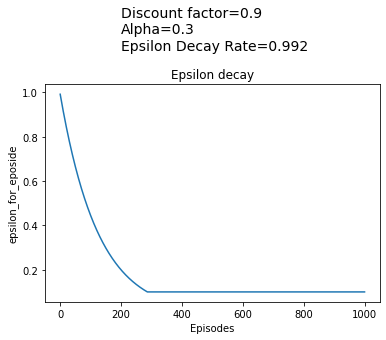

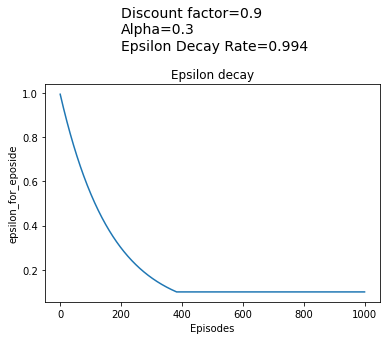

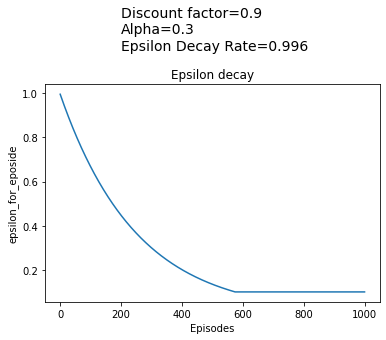

In [111]:
plot_graph(epsilon_decay_rate_three,"epsilon_for_eposide","Epsilon decay")

In [ ]:
Effect of Epsilon decay on Path length

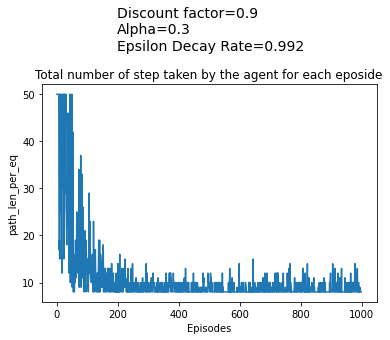

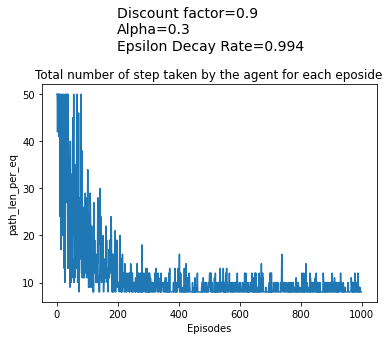

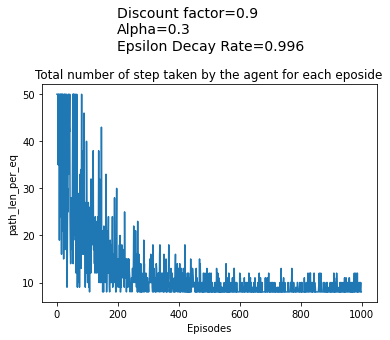

In [ ]:
plot_graph(epsilon_decay_rate_three,"path_len_per_eq","Total number of step taken by the agent for each eposide")

Effect of Epsilon decay on cumaltive rewards

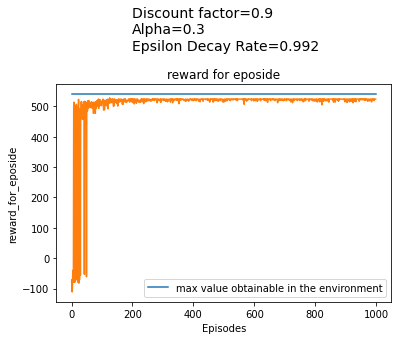

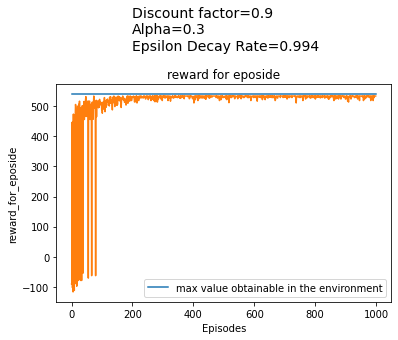

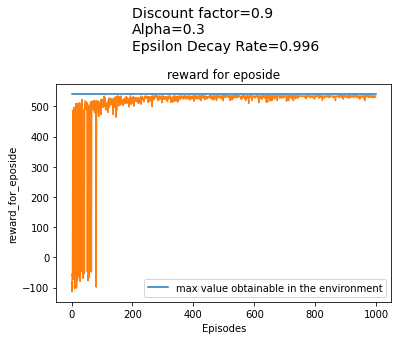

In [ ]:

plot_graph(epsilon_decay_rate_three,"reward_for_eposide","reward for eposide")

In [ ]:
df = df.sort_values(["epsilon_decay_rate","alpha","discount_factor"])
discount_factor_two = df[3:6]  #good
discount_factor_seven = df[18:21] # better

Effect of discount factor on reward

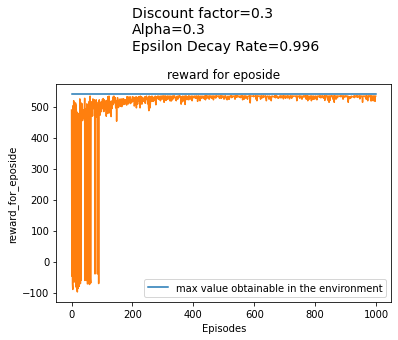

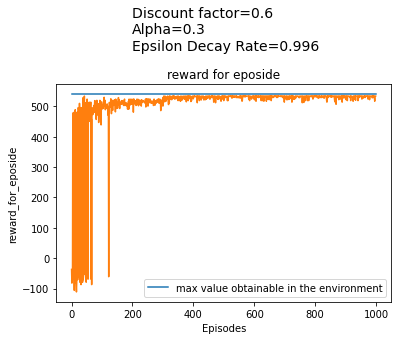

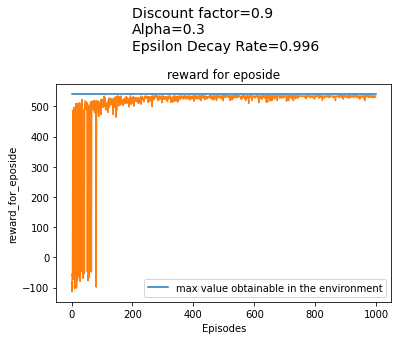

In [ ]:
plot_graph(discount_factor_seven,"reward_for_eposide","reward for eposide")


In [ ]:
All the combinations of hyperparameters that were used to run the SARSA algorithm


In [16]:
hyper_paramenters = ["discount_factor","alpha","epsilon_decay_rate"]
dfsarsa = pd.DataFrame(columns= hyper_paramenters)
values_alpha = [0.3,0.6,0.9]
values_ep = [0.992,0.994,0.996]
for a in values_alpha:
      for b in values_alpha:
          for c in values_ep:
              df2 = pd.DataFrame({"discount_factor" : [a], "alpha" : [b], "epsilon_decay_rate" : [c]})
              dfsarsa = dfsarsa.append(df2)

dfsarsa = dfsarsa.drop_duplicates().reset_index(drop=True)

dfsarsa["reward_for_eposide"] = ""
dfsarsa["epsilon_for_eposide"] = ""
dfsarsa["path_len_per_eq"]= ""
dfsarsa["reached_goal"] = ""
dfsarsa

,discount_factor,alpha,epsilon_decay_rate,reward_for_eposide,epsilon_for_eposide,path_len_per_eq,reached_goal
0,0.3,0.3,0.992,,,,
1,0.3,0.3,0.994,,,,
2,0.3,0.3,0.996,,,,
3,0.3,0.6,0.992,,,,
4,0.3,0.6,0.994,,,,
5,0.3,0.6,0.996,,,,
6,0.3,0.9,0.992,,,,
7,0.3,0.9,0.994,,,,
8,0.3,0.9,0.996,,,,
9,0.6,0.3,0.992,,,,


Running SARSA on all the combination of the hyperparameters on a deterministic environment





In [128]:

index = 0
for i, j in dfsarsa.iterrows(): 
    discount_factor = j[0]
    alpha = j[1]
    epsilon_decay_rate = j[2]
    env = GridEnvironment(False)
    obs = env.reset()
    agent = Agent(env,discount_factor,alpha,epsilon_decay_rate)
    reward_for_eposide,epsilon_for_eposide,path_len_per_eq,reached_goal= agent.sarsa()
    dfsarsa["reward_for_eposide"][index] = reward_for_eposide
    dfsarsa["epsilon_for_eposide"][index] = epsilon_for_eposide
    dfsarsa["path_len_per_eq"][index]= path_len_per_eq
    dfsarsa["reached_goal"][index] = reached_goal
    index += 1
   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/l

Effect of Epsilon decay on SARSA 

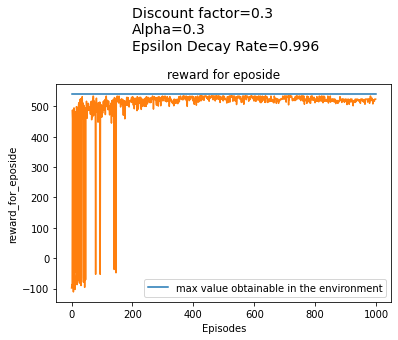

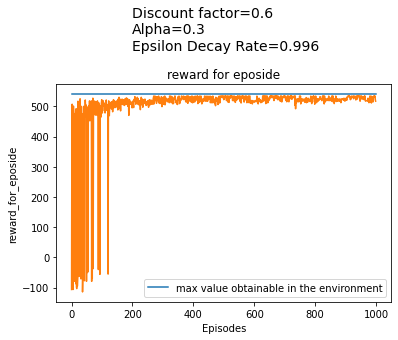

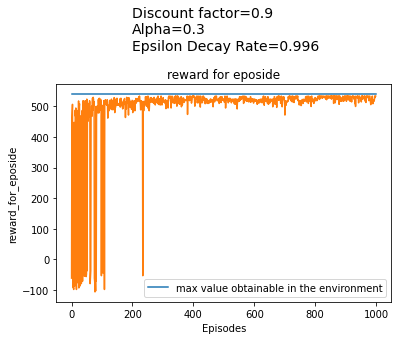

In [129]:
dfsarsa = dfsarsa.sort_values(["epsilon_decay_rate","alpha","discount_factor"])
discount_factor_two = dfsarsa[18:21]  #good
plot_graph(discount_factor_two,"reward_for_eposide","reward for eposide")

Running SARSA on all the combination of the hyperparameters on a stochastic environment

In [ ]:

index = 0
for i, j in dfsarsa.iterrows(): 
    discount_factor = j[0]
    alpha = j[1]
    epsilon_decay_rate = j[2]
    env = GridEnvironment(True)
    obs = env.reset()
    agent = Agent(env,discount_factor,alpha,epsilon_decay_rate)
    reward_for_eposide,epsilon_for_eposide,path_len_per_eq,reached_goal= agent.sarsa()
    dfsarsa["reward_for_eposide"][index] = reward_for_eposide
    dfsarsa["epsilon_for_eposide"][index] = epsilon_for_eposide
    dfsarsa["path_len_per_eq"][index]= path_len_per_eq
    dfsarsa["reached_goal"][index] = reached_goal
    index += 1
   

In [ ]:
dfsarsa = dfsarsa.sort_values(["alpha","discount_factor","epsilon_decay_rate"])
epsilon_decay_rate_one = dfsarsa[0:3]
epsilon_decay_rate_two = dfsarsa[3:6]  
epsilon_decay_rate_three = dfsarsa[6:9] #good
epsilon_decay_rate_four = dfsarsa[9:12]
epsilon_decay_rate_five = dfsarsa[12:15]
epsilon_decay_rate_six = dfsarsa[15:18]
epsilon_decay_rate_seven = dfsarsa[18:21] #
epsilon_decay_rate_eight = dfsarsa[21:24]
epsilon_decay_rate_nine = dfsarsa[24:27]


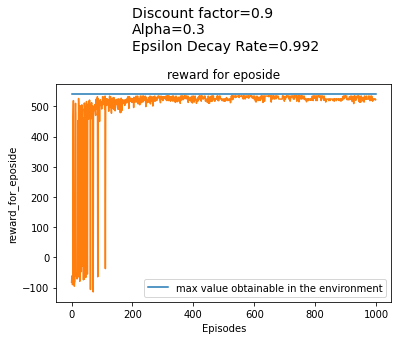

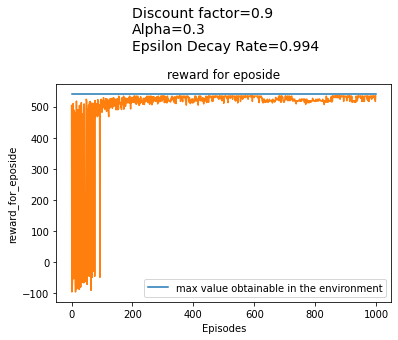

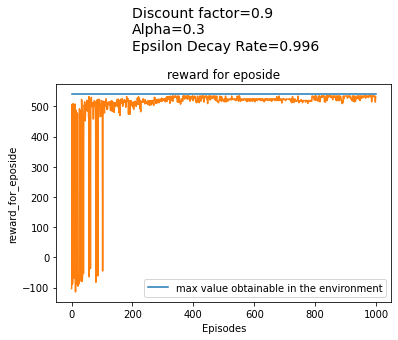

In [ ]:
plot_graph(epsilon_decay_rate_three,"reward_for_eposide","reward for eposide")
